In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../scripts/')

In [244]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
import desispec.io                             # Input/Output functions related to DESI spectra
from desispec import coaddition                # Functions related to coadding the spectra
import targeting

# Set up

In [62]:
plt.rcParams['font.size'] = 16

In [24]:
# Release directory path

specprod = 'fuji'    # Internal name for the EDR
specprod_dir = desispec.io.specprod_root(specprod)

print(specprod_dir)

/global/cfs/cdirs/desi/spectro/redux/fuji


# Find LOW-Z galaxy that should have a detection

In [55]:
target_cat, lowz_sp, lowz_ph = targeting.build_targets (filename='../local_data/targeting_catalogs/LOWZ_TARGETS_FUJI_HEALPIX.CSV')

/tmp/ipykernel_51711/675033531.py:1: DtypeWarning: Columns (25) have mixed types.Specify dtype option on import or set low_memory=False.
  target_cat, lowz_sp, lowz_ph = targeting.build_targets (filename='../local_data/targeting_catalogs/LOWZ_TARGETS_FUJI_HEALPIX.CSV')


In [75]:
roughdf = pd.DataFrame ( index=lowz_sp.index, 
                         columns=['[OIII]4363_flux', '[OII]7320_flux', '[OII]7330_flux',
                                  '[OIII]4363_flux_SNR', '[OII]7320_flux_SNR', '[OII]7330_flux_SNR'])
for idx, name in enumerate(['[OIII]4363','[OII]7320','[OII]7330']):
    col = name.replace('[','').replace(']','_')
    snr = lowz_sp[f'{col}_FLUX']/lowz_sp[f'{col}_FLUX_IVAR']**.5
    roughdf[f'{name}_flux_SNR'] = snr
    roughdf[f'{name}_flux'] = lowz_sp[f'{col}_FLUX']

TARGETID
39627733927462296    False
39627733927465686    False
39627733935851806    False
39627733935851833     True
39627733935851872    False
                     ...  
39633470518985852    False
39633470518986367    False
39633470518986390    False
39633470518986393    False
39633470523179615     True
Name: [OII]7320_flux, Length: 39911, dtype: bool

In [251]:
#candidate = (roughdf['[OIII]4363_flux_SNR']>12.)&(roughdf['[OIII]4363_flux_SNR']<25.)
#candidate = roughdf['[OII]7320_flux'] > 3.
#candidate &= target_cat.reindex(roughdf.index)['Z'] < 0.1
candidate = roughdf['[OIII]4363_flux'] > 10.
print(candidate.sum())
wid = roughdf.loc[candidate].sort_values("[OIII]4363_flux", ascending=True).index[3]

29


# Pull spectrum

In [ ]:
for wid in roughdf.loc[candidate].index:
    row = lowz_sp.loc[wid]
    survey = row['SURVEY']#.astype(str)
    program = row['PROGRAM']#.astype(str)
    hpx = row['HEALPIX']

    healpix_dir = f'{specprod_dir}/healpix'
    tgt_dir = f'{healpix_dir}/{survey}/{program}/{hpx//100}/{hpx}'
    # Filename - 
    coadd_filename = f'coadd-{survey}-{program}-{hpx}.fits'
    
    try:
        coadd_obj = desispec.io.read_spectra(f'{tgt_dir}/{coadd_filename}')
    except:
        continue 
        
    coadd_tgts = coadd_obj.target_ids().data
    assert wid in coadd_tgts

    target_spot = (coadd_tgts == wid)
    coadd_spec = coadd_obj[target_spot]

    # Combined Spectra - 
    spec_combined = coaddition.coadd_cameras(coadd_spec)
    #z = target_cat.loc[wid, 'Z']
    #print(z)

    arr = np.array([spec_combined.wave['brz'], spec_combined.flux['brz'][0]])

    np.savez_compressed(f'../local_data/spectra/{wid}.npz', arr)

INFO:spectra.py:291:read_spectra: iotime 3.546 sec to read coadd-sv3-bright-25952.fits at 2023-01-20T11:06:25.900473
INFO:spectra.py:291:read_spectra: iotime 3.426 sec to read coadd-sv3-dark-25918.fits at 2023-01-20T11:06:32.093139
INFO:spectra.py:291:read_spectra: iotime 3.301 sec to read coadd-sv3-dark-25970.fits at 2023-01-20T11:06:39.113662
INFO:spectra.py:291:read_spectra: iotime 0.197 sec to read coadd-sv3-bright-27656.fits at 2023-01-20T11:06:42.024879
INFO:spectra.py:291:read_spectra: iotime 1.636 sec to read coadd-sv3-bright-27333.fits at 2023-01-20T11:06:43.985320
INFO:spectra.py:291:read_spectra: iotime 5.338 sec to read coadd-sv3-dark-27258.fits at 2023-01-20T11:06:49.866247
INFO:spectra.py:291:read_spectra: iotime 0.529 sec to read coadd-sv3-bright-28030.fits at 2023-01-20T11:06:53.631371
INFO:spectra.py:291:read_spectra: iotime 1.826 sec to read coadd-sv3-bright-28117.fits at 2023-01-20T11:06:56.019608
INFO:spectra.py:291:read_spectra: iotime 2.988 sec to read coadd-sv3-b

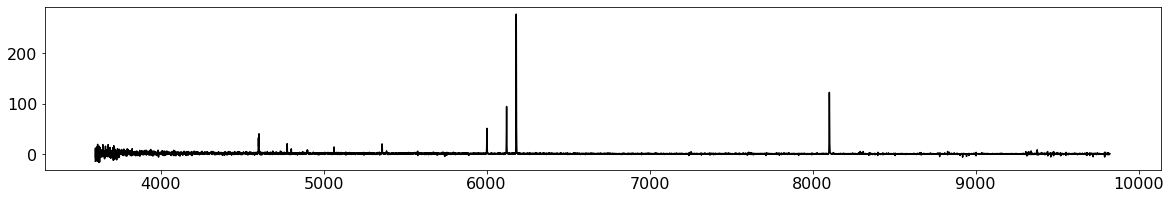

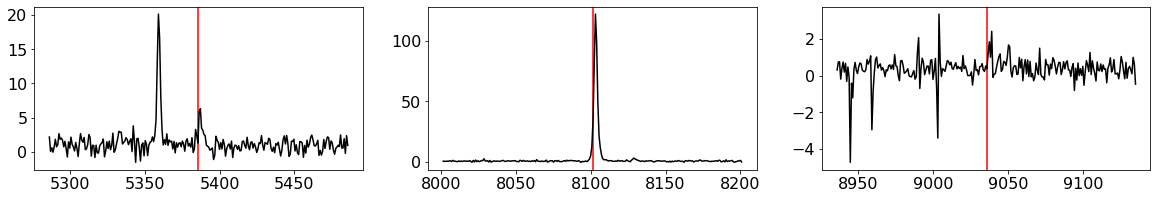

In [240]:
keys = ['brz']
cc_l = ['k']

linezooms = [4363.,6563.,7320]

fig1, ax = plt.subplots(1,1,figsize=(20,3))
fig2, axarr = plt.subplots(1,3,figsize=(20,3))
for idx in range(len(keys)):
    key = keys[idx]
    cc = cc_l[idx]
    
    wv = spec_combined.wave[key]
    flux = spec_combined.flux[key][0]
    ax.plot(wv, flux, color=cc)

for idx in range(len(linezooms)):
    obs_line = linezooms[idx]*(1.+z)
    '''
    if obs_line < 5800:
        key = 'b'
    elif obs_line < 7520:
        key = 'r'
    else:
        key = 'z'
    '''
    key = 'brz'
    wv = spec_combined.wave[key]
    flux = spec_combined.flux[key][0]    
    
    mask = abs(wv - obs_line) < 100.
    axarr[idx].plot ( wv[mask], flux[mask], color='k')
    axarr[idx].axvline ( obs_line, color='r', zorder=0 )
#ax.axvline ( 6563.*(1.+z), zorder=0 )